# Finding entity classes in embeddings

In this notebook we're going to use embeddings to find entity classes and how they correlate with other things

In [6]:
from sklearn import svm
from keras.utils import get_file
import os
import gensim
import numpy as np
import random
import requests
import geopandas as gpd
from IPython.core.pylabtools import figsize
import csv
from pathlib import Path

In [7]:
%matplotlib inline
figsize(12, 8)

As before, let's load up the model:

In [8]:
HOME_PATH = Path.home()
MODELS_PATH = HOME_PATH / 'models'
DATA_PATH = HOME_PATH / 'data'

assert MODELS_PATH.is_dir()
assert DATA_PATH.is_dir()

In [9]:
MODEL = 'GoogleNews-vectors-negative300.bin'
zipped = MODEL + '.gz'
URL = 'https://s3.amazonaws.com/dl4j-distribution/' + zipped
path = get_file(MODELS_PATH / zipped, URL)
unzipped = MODELS_PATH / MODEL

if not unzipped.is_file():
    with open(unzipped, 'wb') as fout:
        zcat = subprocess.Popen(['zcat'], stdin=open(path), stdout=fout)
        zcat.wait()
    
assert unzipped.is_file()
print('Model file is located at', unzipped)

Model file is located at /home/mrduhart/models/GoogleNews-vectors-negative300.bin


In [141]:
%%time

VOCAB_LIMIT = int(2.5e5)
model = (
    gensim
    .models
    .KeyedVectors
    .load_word2vec_format(unzipped, binary=True, limit=VOCAB_LIMIT)
)

CPU times: user 13.2 s, sys: 2.48 s, total: 15.7 s
Wall time: 16 s


Most similar to a bunch of countries are some other countries!

In [11]:
model.most_similar(positive=['Germany'])

[('Austria', 0.7461062669754028),
 ('German', 0.7178750038146973),
 ('Germans', 0.6628648042678833),
 ('Switzerland', 0.6506868004798889),
 ('Hungary', 0.6504982709884644),
 ('Netherlands', 0.6437495946884155),
 ('Cologne', 0.6430779695510864),
 ('Poland', 0.6326087713241577),
 ('Berlin', 0.6313546895980835),
 ('Europe', 0.6301708221435547)]

## Training a classifier to extract the countries 

No we'll create a training set with countries and non countries and get a support vector machine to learn the difference.

In [13]:
countries = list(csv.DictReader(open('data/countries.csv')))
countries[:10]

[OrderedDict([('name', 'Canada'), ('cc', 'ca'), ('cc3', 'can')]),
 OrderedDict([('name', 'Turkmenistan'), ('cc', 'tm'), ('cc3', 'tkm')]),
 OrderedDict([('name', 'Ethiopia'), ('cc', 'et'), ('cc3', 'eth')]),
 OrderedDict([('name', 'Swaziland'), ('cc', 'sz'), ('cc3', 'swz')]),
 OrderedDict([('name', 'Czech_Republic'), ('cc', 'cz'), ('cc3', 'cze')]),
 OrderedDict([('name', 'Cameroon'), ('cc', 'cm'), ('cc3', 'cmr')]),
 OrderedDict([('name', 'UAE'), ('cc', 'ae'), ('cc3', 'are')]),
 OrderedDict([('name', 'Liberia'), ('cc', 'lr'), ('cc3', 'lbr')]),
 OrderedDict([('name', 'Netherlands'), ('cc', 'nl'), ('cc3', 'nld')]),
 OrderedDict([('name', 'East_Timor'), ('cc', 'tl'), ('cc3', 'tls')])]

In [99]:
random.seed(0)
positive = [x['name'] for x in random.sample(countries, 40)]
positive[:10]

['Samoa',
 'Lesotho',
 'Tanzania',
 'Austria',
 'Bulgaria',
 'Mauritius',
 'Ivory_Coast',
 'Congo',
 'Tonga',
 'Spain']

In [100]:
random.seed(0)
negative = random.sample(model.vocab.keys(), 5000)
negative[:10]

['Caroline_Kennedy',
 'amicus_brief',
 'Aldi',
 'venture',
 'backyards',
 'Gorillaz',
 'ageless',
 'Syngenta',
 'Recommendations',
 'Hut']

In [115]:
labeled = [(p, 1) for p in positive] + [(n, 0) for n in negative]
random.shuffle(labeled)
X = np.asarray([model[w] for w, l in labeled if w in model])
y = np.asarray([l for w, l in labeled if w in model])
X.shape, y.shape

((5039, 300), (5039,))

In [104]:
TRAINING_FRACTION = 0.5
cut_off = int(TRAINING_FRACTION * len(labeled))
clf = svm.SVC(kernel='linear')
clf.fit(X[:cut_off], y[:cut_off])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [105]:
score_tr = clf.score(X[:cut_off], y[:cut_off])
score_ts = clf.score(X[cut_off:], y[cut_off:])

print('Train set accuracy: %0.3f' % score_tr)
print('Test set accuracy: %0.3f' % score_ts)

Train set accuracy: 1.000
Test set accuracy: 0.996


We did alright, 99.9% precision:

In [106]:
res = clf.predict(X[cut_off:])

missed = [country for (pred, truth, country) in 
 zip(res, y[cut_off:], labeled[cut_off:]) if pred != truth]

score_ts = 100 - 100.0 * len(missed) / len(res)
print('Test set accuracy: %0.3f' % score_ts)
print('%d missed examples in test set:\n%s' 
      % (len(missed), '\n'.join([c for c, l in missed]))
     )

Test set accuracy: 99.643
9 missed examples in test set:
Rainfall
Excluding
charitable_organizations
Afghanistan
lull
Sethi
##yrs
hull
Trot


We can now run the classifier over all the words to extract the countries:

In [107]:
all_predictions = clf.predict(model.vectors)

In [108]:
idx = np.where(all_predictions)[0]
res = np.array(model.index2word)[idx][:150].tolist()
random.seed(0)
random.sample(res, 10)

['Zambia',
 'Persian_Gulf',
 'South_Africa',
 'Ethiopia',
 'Madagascar',
 'Laos',
 'Botswana',
 'Algeria',
 'Mali',
 'Bolivia']

In [109]:
country_to_idx = {country['name']: idx for idx, country in enumerate(countries)}
country_vecs = np.asarray(
    [model[c['name']] 
     for c in countries 
     if c['name'] in model]
)
country_vecs.shape

(182, 300)

Quick sanity check to see what is similar to Canada:

In [110]:
dists = np.dot(country_vecs, country_vecs[country_to_idx['Canada']])
for idx in reversed(np.argsort(dists)[-10:]):
    print(countries[idx]['name'], dists[idx])

Canada 7.544024
Peru 3.9619699
French_Guiana 3.9392407
Angola 3.838145
Samoa 3.8102932
Indonesia 3.8042789
France 3.703874
Nigeria 3.671101
Madagascar 3.6240416
Montenegro 3.5374339


Let's visualize the decision boundary of the classifier:

In [111]:
# TBD

## Ranking countries for a specific term

In [117]:
def rank_countries(term, topn=10, field='name'):
    if not term in model:
        return []
    vec = model[term]
    dists = np.dot(country_vecs, vec)
    return [(countries[idx][field], dists[idx])
            for idx in reversed(np.argsort(dists)[-topn:])]

In [124]:
rank_countries('cricket')

[('Saudi_Arabia', 5.9227667),
 ('Austria', 5.336525),
 ('Lesotho', 5.192489),
 ('Guinea', 4.948408),
 ('Macedonia', 3.9162838),
 ('Taiwan', 3.7579951),
 ('Ivory_Coast', 3.75044),
 ('Malawi', 3.6561499),
 ('Peru', 3.6420286),
 ('Colombia', 3.6085677)]

Now let's visualize this on a world map:

In [122]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"(POLYGON ((180 -16.06713266364245, 180 -16.555..."
1,53950935,Africa,Tanzania,TZA,150600.0,POLYGON ((33.90371119710453 -0.950000000000000...
2,603253,Africa,W. Sahara,ESH,906.5,POLYGON ((-8.665589565454809 27.65642588959236...
3,35623680,North America,Canada,CAN,1674000.0,"(POLYGON ((-122.84 49.00000000000011, -122.974..."
4,326625791,North America,United States of America,USA,18560000.0,"(POLYGON ((-122.84 49.00000000000011, -120 49...."


We can now plot some maps!

In [133]:
def map_term(term):
    d = {cc3.upper(): dist 
         for cc3, dist in rank_countries(term, topn=0, field='cc3')}
    world[term] = world['iso_a3'].map(d)
    world[term] /= world[term].max()
    world.dropna().plot(term, cmap='OrRd')

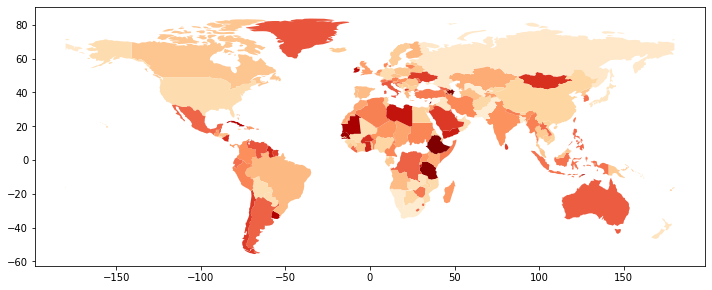

In [142]:
map_term('coffee')

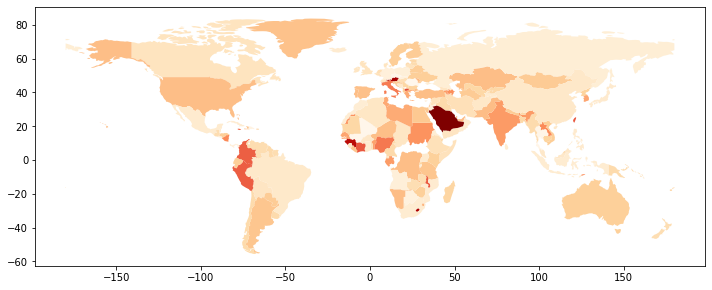

In [143]:
map_term('cricket')

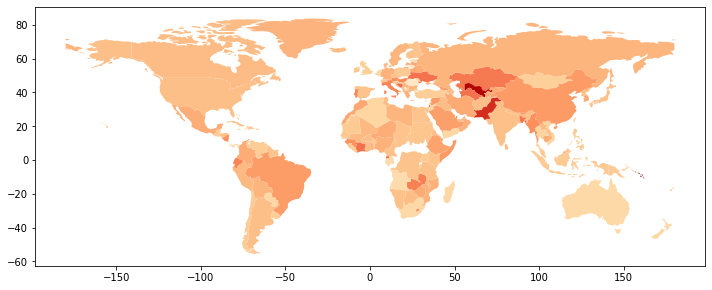

In [144]:
map_term('China')

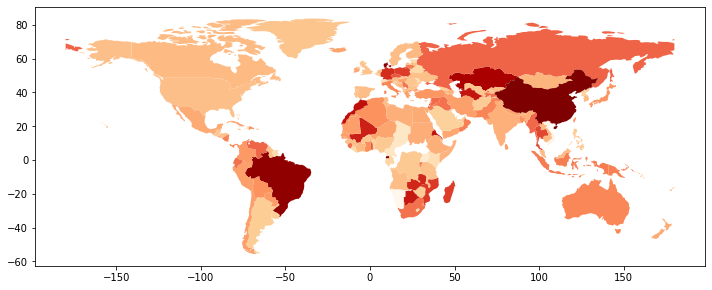

In [145]:
map_term('vodka')